# Setup

In [1]:
!nvidia-smi -L
!nvidia-smi

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-294e7e2e-418e-5872-1fe0-74910b01dca6)
Mon May 16 01:11:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
           

In [59]:
tf.__version__

'2.8.0'

In [2]:
%%capture
!rm -rf sample_data imagenet_class_index.json
!wget -O imagenet_class_index.json https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [3]:
import gc
import json
import os
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#sample_from_datasets


mpl.rcParams["figure.figsize"] = (8, 8)
mpl.rcParams["axes.grid"] = False

SEED = 301

In [4]:
def reset_tensorflow_keras_backend():
    import tensorflow as tf

    tf.compat.v1.reset_default_graph()
    _ = gc.collect()


reset_tensorflow_keras_backend()

In [5]:
index_label_map = json.load(open("imagenet_class_index.json", "r"))

# Load and Process Dataset

In [6]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image, label=None):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return (image, label)


# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [7]:
# Construct a tf.data.Dataset
imagenet_r_train = tfds.load("imagenet_r", data_dir="data", split="test[:80%]", shuffle_files=True, as_supervised=True, try_gcs=True)
imagenet_r_test = tfds.load("imagenet_r", data_dir="data", split="test[80%:]", shuffle_files=True, as_supervised=True, try_gcs=True)

print("Training set size:", len(imagenet_r_train))
print("Test set size:", len(imagenet_r_test))

imagenet_r_train = imagenet_r_train.map(preprocess)
imagenet_r_test = imagenet_r_test.map(preprocess)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to data/imagenet_r/0.1.0.incompleteEWAV8H/imagenet_r-test.tfrecord


  0%|          | 0/30000 [00:00<?, ? examples/s]

Dataset imagenet_r downloaded and prepared to data/imagenet_r/0.1.0. Subsequent calls will reuse this data.
Training set size: 24000
Test set size: 6000


In [8]:
# Helper function to display image
def display_images(image, label_index):
    plt.figure()
    plt.imshow(image * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
    plt.title(f"Real Label: {index_label_map[str(label_index)]}  |  Label Index: {label_index}")
    plt.show()

In [9]:
X_test_adv = []
y_test = []

for example in imagenet_r_test:
    (local_image, local_label_index) = example

    local_image = local_image.numpy()
    local_label_index = int(local_label_index)

    # display_images(local_image, local_label_index)

    X_test_adv.append(local_image)
    y_test.append(local_label_index)

X_test_adv = np.array(X_test_adv)
y_test = np.array(y_test)

In [10]:
imagenet_r_train = imagenet_r_train.shuffle(len(imagenet_r_train))
imagenet_r_train = imagenet_r_train.cache()
imagenet_r_train = imagenet_r_train.batch(128)
imagenet_r_train = imagenet_r_train.prefetch(tf.data.AUTOTUNE)

imagenet_r_test = imagenet_r_test.shuffle(len(imagenet_r_test))
imagenet_r_test = imagenet_r_test.batch(128)
imagenet_r_test = imagenet_r_test.prefetch(tf.data.AUTOTUNE)

# Load Pre-trained Model

In [11]:
learning_rate = 0.0001
epochs = 4

performance_history = {}

In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights="imagenet")
pretrained_model.trainable = False

pretrained_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    # metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    metrics=["accuracy"],
)

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


In [13]:
reset_tensorflow_keras_backend()
loss0, accuracy0 = pretrained_model.evaluate(imagenet_r_test)
print("BaseA Model Initial Loss: {:.4f}".format(loss0))
print("BaseA Model Initial Accuracy: {:.4f}".format(accuracy0))

47/47 [==============================] - 21s 69ms/step - loss: 5.2801 - accuracy: 0.2070
BaseA Model Initial Loss: 5.2801
BaseA Model Initial Accuracy: 0.2070


---

# Transfer Learning Model

In [14]:
def get_a_n_b(pretrained_model, n_layers_to_copy, freeze, training_data, validation_data):
    local_model = None
    local_model = tf.keras.applications.MobileNetV2(include_top=True)
    local_model.trainable = True

    for i in range(n_layers_to_copy + 1):
        local_model.layers[i].set_weights(pretrained_model.layers[i].get_weights())
        if freeze:
            local_model.layers[i].trainable = False
        else:
            local_model.layers[i].trainable = True

    local_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

    initial_epochs = int(epochs / 2)
    fine_tune_epochs = int(epochs / 2)

    # Fine tuning
    if freeze == False and n_layers_to_copy != -1:
        local_history = local_model.fit(imagenet_r_train, epochs=initial_epochs, validation_data=imagenet_r_test)

        local_model.trainable = True

        local_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate / 10), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

        total_epochs = initial_epochs + fine_tune_epochs - 1

        finetuning_history = local_model.fit(imagenet_r_train, epochs=total_epochs, initial_epoch=local_history.epoch[-1], validation_data=imagenet_r_test)

        finetuning_history.history["val_accuracy"] = local_history.history["val_accuracy"] + finetuning_history.history["val_accuracy"]

        return local_model, finetuning_history
    else:
        local_history = local_model.fit(imagenet_r_train, epochs=epochs, validation_data=imagenet_r_test)
        return local_model, local_history

# Train Base Model (i.e. $BnB$)

In [15]:
reset_tensorflow_keras_backend()
print("base_B:")
base_B, base_B_history = get_a_n_b(pretrained_model=pretrained_model, n_layers_to_copy=-1, freeze=False, training_data=imagenet_r_train, validation_data=imagenet_r_test)
performance_history["base_B"] = base_B_history.history

base_B:
Epoch 1/4
188/188 [==============================] - 123s 490ms/step - loss: 2.4292 - accuracy: 0.4995 - val_loss: 2.1409 - val_accuracy: 0.5262
Epoch 2/4
188/188 [==============================] - 90s 479ms/step - loss: 1.1814 - accuracy: 0.7271 - val_loss: 1.9716 - val_accuracy: 0.5548
Epoch 3/4
188/188 [==============================] - 89s 474ms/step - loss: 0.6778 - accuracy: 0.8596 - val_loss: 1.8860 - val_accuracy: 0.5763
Epoch 4/4
188/188 [==============================] - 89s 476ms/step - loss: 0.3729 - accuracy: 0.9380 - val_loss: 1.8378 - val_accuracy: 0.5907


# Train Transfer Learning Model (i.e. $AnB$ and $AnB+$)

In [16]:
reset_tensorflow_keras_backend()
print("A_4blocks_B:")
A_4blocks_B, A_4blocks_B_history = get_a_n_b(pretrained_model=pretrained_model, n_layers_to_copy=44, freeze=False, training_data=imagenet_r_train, validation_data=imagenet_r_test)
performance_history["A_4blocks_B"] = A_4blocks_B_history.history

print("\nA_4blocks_B_freeze")
A_4blocks_B_freeze, A_4blocks_B_freeze_history = get_a_n_b(pretrained_model=pretrained_model, n_layers_to_copy=44, freeze=True, training_data=imagenet_r_train, validation_data=imagenet_r_test)
performance_history["A_4blocks_B_freeze"] = A_4blocks_B_freeze_history.history

A_4blocks_B:
Epoch 1/2
188/188 [==============================] - 92s 470ms/step - loss: 2.4294 - accuracy: 0.4989 - val_loss: 2.1460 - val_accuracy: 0.5227
Epoch 2/2
188/188 [==============================] - 88s 468ms/step - loss: 1.1812 - accuracy: 0.7280 - val_loss: 1.9867 - val_accuracy: 0.5552
Epoch 2/3
188/188 [==============================] - 98s 480ms/step - loss: 0.6635 - accuracy: 0.8638 - val_loss: 1.8529 - val_accuracy: 0.5762
Epoch 3/3
188/188 [==============================] - 89s 475ms/step - loss: 0.5924 - accuracy: 0.8816 - val_loss: 1.7694 - val_accuracy: 0.5965

A_4blocks_B_freeze
Epoch 1/4
188/188 [==============================] - 33s 158ms/step - loss: 2.4426 - accuracy: 0.4978 - val_loss: 2.1221 - val_accuracy: 0.5303
Epoch 2/4
188/188 [==============================] - 29s 155ms/step - loss: 1.1997 - accuracy: 0.7249 - val_loss: 1.9599 - val_accuracy: 0.5607
Epoch 3/4
188/188 [==============================] - 29s 154ms/step - loss: 0.6972 - accuracy: 0.8538 -

In [17]:
reset_tensorflow_keras_backend()
print("A_8blocks_B")
A_8blocks_B, A_8blocks_B_history = get_a_n_b(pretrained_model=pretrained_model, n_layers_to_copy=80, freeze=False, training_data=imagenet_r_train, validation_data=imagenet_r_test)
performance_history["A_8blocks_B"] = A_8blocks_B_history.history

print("\nA_8blocks_B_freeze")
A_8blocks_B_freeze, A_8blocks_B_freeze_history = get_a_n_b(pretrained_model=pretrained_model, n_layers_to_copy=80, freeze=True, training_data=imagenet_r_train, validation_data=imagenet_r_test)
performance_history["A_8blocks_B_freeze"] = A_8blocks_B_freeze_history.history

A_8blocks_B
Epoch 1/2
188/188 [==============================] - 91s 465ms/step - loss: 2.4288 - accuracy: 0.4995 - val_loss: 2.1434 - val_accuracy: 0.5243
Epoch 2/2
188/188 [==============================] - 88s 468ms/step - loss: 1.1798 - accuracy: 0.7271 - val_loss: 1.9848 - val_accuracy: 0.5522
Epoch 2/3
188/188 [==============================] - 97s 474ms/step - loss: 0.6631 - accuracy: 0.8644 - val_loss: 1.8481 - val_accuracy: 0.5762
Epoch 3/3
188/188 [==============================] - 88s 470ms/step - loss: 0.5919 - accuracy: 0.8830 - val_loss: 1.7663 - val_accuracy: 0.5963

A_8blocks_B_freeze
Epoch 1/4
188/188 [==============================] - 30s 142ms/step - loss: 2.4861 - accuracy: 0.4927 - val_loss: 2.1940 - val_accuracy: 0.5183
Epoch 2/4
188/188 [==============================] - 26s 138ms/step - loss: 1.2620 - accuracy: 0.7113 - val_loss: 2.0601 - val_accuracy: 0.5435
Epoch 3/4
188/188 [==============================] - 26s 139ms/step - loss: 0.7675 - accuracy: 0.8354 - 

In [18]:
reset_tensorflow_keras_backend()
print("A_12blocks_B")
A_12blocks_B, A_12blocks_B_history = get_a_n_b(pretrained_model=pretrained_model, n_layers_to_copy=115, freeze=False, training_data=imagenet_r_train, validation_data=imagenet_r_test)
performance_history["A_12blocks_B"] = A_12blocks_B_history.history

print("\nA_12blocks_B_freeze")
A_12blocks_B_freeze, A_12blocks_B_freeze_history = get_a_n_b(pretrained_model=pretrained_model, n_layers_to_copy=115, freeze=True, training_data=imagenet_r_train, validation_data=imagenet_r_test)
performance_history["A_12blocks_B_freeze"] = A_12blocks_B_freeze_history.history

A_12blocks_B
Epoch 1/2
188/188 [==============================] - 93s 475ms/step - loss: 2.4289 - accuracy: 0.5002 - val_loss: 2.1412 - val_accuracy: 0.5263
Epoch 2/2
188/188 [==============================] - 89s 475ms/step - loss: 1.1807 - accuracy: 0.7275 - val_loss: 1.9824 - val_accuracy: 0.5525
Epoch 2/3
188/188 [==============================] - 98s 479ms/step - loss: 0.6633 - accuracy: 0.8632 - val_loss: 1.8453 - val_accuracy: 0.5780
Epoch 3/3
188/188 [==============================] - 89s 475ms/step - loss: 0.5922 - accuracy: 0.8824 - val_loss: 1.7638 - val_accuracy: 0.5963

A_12blocks_B_freeze
Epoch 1/4
188/188 [==============================] - 27s 132ms/step - loss: 2.6612 - accuracy: 0.4593 - val_loss: 2.5053 - val_accuracy: 0.4695
Epoch 2/4
188/188 [==============================] - 23s 125ms/step - loss: 1.4936 - accuracy: 0.6596 - val_loss: 2.3084 - val_accuracy: 0.5032
Epoch 3/4
188/188 [==============================] - 24s 126ms/step - loss: 1.0146 - accuracy: 0.7761 

In [19]:
reset_tensorflow_keras_backend()
print("A_16blocks_B")
A_16blocks_B, A_16blocks_B_history = get_a_n_b(pretrained_model=pretrained_model, n_layers_to_copy=153, freeze=False, training_data=imagenet_r_train, validation_data=imagenet_r_test)
performance_history["A_16blocks_B"] = A_16blocks_B_history.history

print("\nA_16blocks_B_freeze")
A_16blocks_B_freeze, A_16blocks_B_freeze_history = get_a_n_b(pretrained_model=pretrained_model, n_layers_to_copy=153, freeze=True, training_data=imagenet_r_train, validation_data=imagenet_r_test)
performance_history["A_16blocks_B_freeze"] = A_16blocks_B_freeze_history.history

A_16blocks_B
Epoch 1/2
188/188 [==============================] - 92s 469ms/step - loss: 2.4294 - accuracy: 0.4995 - val_loss: 2.1527 - val_accuracy: 0.5243
Epoch 2/2
188/188 [==============================] - 89s 473ms/step - loss: 1.1810 - accuracy: 0.7273 - val_loss: 1.9848 - val_accuracy: 0.5542
Epoch 2/3
188/188 [==============================] - 98s 479ms/step - loss: 0.6638 - accuracy: 0.8653 - val_loss: 1.8501 - val_accuracy: 0.5787
Epoch 3/3
188/188 [==============================] - 89s 474ms/step - loss: 0.5926 - accuracy: 0.8825 - val_loss: 1.7673 - val_accuracy: 0.5965

A_16blocks_B_freeze
Epoch 1/4
188/188 [==============================] - 24s 118ms/step - loss: 3.6752 - accuracy: 0.3228 - val_loss: 3.1780 - val_accuracy: 0.3743
Epoch 2/4
188/188 [==============================] - 21s 114ms/step - loss: 3.0417 - accuracy: 0.3814 - val_loss: 2.9799 - val_accuracy: 0.3977
Epoch 3/4
188/188 [==============================] - 21s 114ms/step - loss: 2.8280 - accuracy: 0.4110 

# Plot Transfer Learning Performance

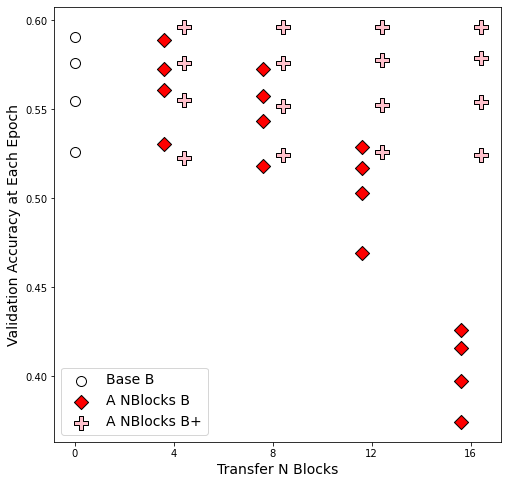

In [61]:
plt.figure()

# Base B
plt.scatter([0, 0, 0, 0], performance_history["base_B"]["val_accuracy"], s=100, marker="o", color="white", edgecolor="black", linewidth=1, label="Base B")

plt.scatter([0.9, 0.9, 0.9, 0.9], performance_history["A_4blocks_B_freeze"]["val_accuracy"], s=100, marker="D", color="red", edgecolor="black", linewidth=1, label="A NBlocks B")
plt.scatter([1.1, 1.1, 1.1, 1.1], performance_history["A_4blocks_B"]["val_accuracy"], s=200, marker="P", color="pink", edgecolor="black", linewidth=1, label="A NBlocks B+")

plt.scatter([1.9, 1.9, 1.9, 1.9], performance_history["A_8blocks_B_freeze"]["val_accuracy"], s=100, marker="D", color="red", edgecolor="black", linewidth=1)
plt.scatter([2.1, 2.1, 2.1, 2.1], performance_history["A_8blocks_B"]["val_accuracy"], s=200, marker="P", color="pink", edgecolor="black", linewidth=1)

plt.scatter([2.9, 2.9, 2.9, 2.9], performance_history["A_12blocks_B_freeze"]["val_accuracy"], s=100, marker="D", color="red", edgecolor="black", linewidth=1)
plt.scatter([3.1, 3.1, 3.1, 3.1], performance_history["A_12blocks_B"]["val_accuracy"], s=200, marker="P", color="pink", edgecolor="black", linewidth=1)

plt.scatter([3.9, 3.9, 3.9, 3.9], performance_history["A_16blocks_B_freeze"]["val_accuracy"], s=100, marker="D", color="red", edgecolor="black", linewidth=1)
plt.scatter([4.1, 4.1, 4.1, 4.1], performance_history["A_16blocks_B"]["val_accuracy"], s=200, marker="P", color="pink", edgecolor="black", linewidth=1)

plt.xticks(ticks=[0, 1, 2, 3, 4], labels=[0, 4, 8, 12, 16])

plt.xlabel("Transfer N Blocks", fontsize=14)
plt.ylabel("Validation Accuracy at Each Epoch", fontsize=14)
plt.legend(loc="lower left", prop={"size": 14})

plt.savefig("transfer_learning_performance.png", dpi=1200, bbox_inches="tight")
plt.show()

# Adversarial Example

In [21]:
loss_object = tf.keras.losses.CategoricalCrossentropy()


def create_adversarial_pattern(input_image, input_label, model):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad


def create_adversatial_image(image, real_label_index, model, epsilon):
    image = image[None, ...]

    image_probs = model.predict(image)

    # Get the input label of the image.
    label = tf.one_hot(real_label_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    perturbations = create_adversarial_pattern(image, label, model)

    adv_x = image + epsilon * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)

    return adv_x[0].numpy()

In [22]:
for i in range(len(X_test_adv)):
    X_test_adv[i] = create_adversatial_image(tf.convert_to_tensor(X_test_adv[i]), y_test[i], pretrained_model, 0.01)
    if i % 500 == 0:
        print(f"Progress: {i+1} / {len(X_test_adv)}")

adversarial_performance = {}

Progress: 1 / 6000
Progress: 501 / 6000
Progress: 1001 / 6000
Progress: 1501 / 6000
Progress: 2001 / 6000
Progress: 2501 / 6000
Progress: 3001 / 6000
Progress: 3501 / 6000
Progress: 4001 / 6000
Progress: 4501 / 6000
Progress: 5001 / 6000
Progress: 5501 / 6000


In [23]:
reset_tensorflow_keras_backend()

adversarial_performance["A_4blocks_B"] = {}

_, natural_accuracy = A_4blocks_B.evaluate(imagenet_r_test)
adversarial_performance["A_4blocks_B"]["natural_accuracy"] = natural_accuracy
print("A_4blocks_B Natural Accuracy: {:.4f}".format(natural_accuracy))

_, adv_accuracy = A_4blocks_B.evaluate(x=X_test_adv, y=y_test)
adversarial_performance["A_4blocks_B"]["adv_accuracy"] = adv_accuracy
print("A_4blocks_B Adversarial Accuracy: {:.4f}".format(adv_accuracy))

47/47 [==============================] - 10s 64ms/step - loss: 1.7694 - accuracy: 0.5965
A_4blocks_B Natural Accuracy: 0.5965
188/188 [==============================] - 4s 21ms/step - loss: 4.1347 - accuracy: 0.2592
A_4blocks_B Adversarial Accuracy: 0.2592


In [24]:
reset_tensorflow_keras_backend()

adversarial_performance["A_4blocks_B_freeze"] = {}

_, natural_accuracy = A_4blocks_B_freeze.evaluate(imagenet_r_test)
adversarial_performance["A_4blocks_B_freeze"]["natural_accuracy"] = natural_accuracy
print("A_4blocks_B_freeze Natural Accuracy: {:.4f}".format(natural_accuracy))

_, adv_accuracy = A_4blocks_B_freeze.evaluate(x=X_test_adv, y=y_test)
adversarial_performance["A_4blocks_B_freeze"]["adv_accuracy"] = adv_accuracy
print("A_4blocks_B_freeze Adversarial Accuracy: {:.4f}".format(adv_accuracy))

47/47 [==============================] - 10s 64ms/step - loss: 1.8264 - accuracy: 0.5890
A_4blocks_B_freeze Natural Accuracy: 0.5890
188/188 [==============================] - 4s 20ms/step - loss: 4.3694 - accuracy: 0.2267
A_4blocks_B_freeze Adversarial Accuracy: 0.2267


In [25]:
reset_tensorflow_keras_backend()

adversarial_performance["A_8blocks_B"] = {}

_, natural_accuracy = A_8blocks_B.evaluate(imagenet_r_test)
adversarial_performance["A_8blocks_B"]["natural_accuracy"] = natural_accuracy
print("A_8blocks_B Natural Accuracy: {:.4f}".format(natural_accuracy))

_, adv_accuracy = A_8blocks_B.evaluate(x=X_test_adv, y=y_test)
adversarial_performance["A_8blocks_B"]["adv_accuracy"] = adv_accuracy
print("A_8blocks_B Adversarial Accuracy: {:.4f}".format(adv_accuracy))

47/47 [==============================] - 10s 64ms/step - loss: 1.7663 - accuracy: 0.5963
A_8blocks_B Natural Accuracy: 0.5963
188/188 [==============================] - 4s 20ms/step - loss: 4.1327 - accuracy: 0.2583
A_8blocks_B Adversarial Accuracy: 0.2583


In [26]:
reset_tensorflow_keras_backend()

adversarial_performance["A_8blocks_B_freeze"] = {}

_, natural_accuracy = A_8blocks_B_freeze.evaluate(imagenet_r_test)
adversarial_performance["A_8blocks_B_freeze"]["natural_accuracy"] = natural_accuracy
print("A_8blocks_B_freeze Natural Accuracy: {:.4f}".format(natural_accuracy))

_, adv_accuracy = A_8blocks_B_freeze.evaluate(x=X_test_adv, y=y_test)
adversarial_performance["A_8blocks_B_freeze"]["adv_accuracy"] = adv_accuracy
print("A_8blocks_B_freeze Adversarial Accuracy: {:.4f}".format(adv_accuracy))

47/47 [==============================] - 10s 64ms/step - loss: 1.9244 - accuracy: 0.5727
A_8blocks_B_freeze Natural Accuracy: 0.5727
188/188 [==============================] - 4s 20ms/step - loss: 4.6939 - accuracy: 0.1932
A_8blocks_B_freeze Adversarial Accuracy: 0.1932


In [27]:
reset_tensorflow_keras_backend()

adversarial_performance["A_12blocks_B"] = {}

_, natural_accuracy = A_12blocks_B.evaluate(imagenet_r_test)
adversarial_performance["A_12blocks_B"]["natural_accuracy"] = natural_accuracy
print("A_12blocks_B Natural Accuracy: {:.4f}".format(natural_accuracy))

_, adv_accuracy = A_12blocks_B.evaluate(x=X_test_adv, y=y_test)
adversarial_performance["A_12blocks_B"]["adv_accuracy"] = adv_accuracy
print("A_12blocks_B Adversarial Accuracy: {:.4f}".format(adv_accuracy))

47/47 [==============================] - 9s 64ms/step - loss: 1.7638 - accuracy: 0.5963
A_12blocks_B Natural Accuracy: 0.5963
188/188 [==============================] - 4s 20ms/step - loss: 4.1326 - accuracy: 0.2595
A_12blocks_B Adversarial Accuracy: 0.2595


In [28]:
reset_tensorflow_keras_backend()

adversarial_performance["A_12blocks_B_freeze"] = {}

_, natural_accuracy = A_12blocks_B_freeze.evaluate(imagenet_r_test)
adversarial_performance["A_12blocks_B_freeze"]["natural_accuracy"] = natural_accuracy
print("A_12blocks_B_freeze Natural Accuracy: {:.4f}".format(natural_accuracy))

_, adv_accuracy = A_12blocks_B_freeze.evaluate(x=X_test_adv, y=y_test)
adversarial_performance["A_12blocks_B_freeze"]["adv_accuracy"] = adv_accuracy
print("A_12blocks_B_freeze Adversarial Accuracy: {:.4f}".format(adv_accuracy))

47/47 [==============================] - 10s 64ms/step - loss: 2.1939 - accuracy: 0.5287
A_12blocks_B_freeze Natural Accuracy: 0.5287
188/188 [==============================] - 4s 20ms/step - loss: 5.1790 - accuracy: 0.1442
A_12blocks_B_freeze Adversarial Accuracy: 0.1442


In [29]:
reset_tensorflow_keras_backend()

adversarial_performance["A_16blocks_B"] = {}

_, natural_accuracy = A_16blocks_B.evaluate(imagenet_r_test)
adversarial_performance["A_16blocks_B"]["natural_accuracy"] = natural_accuracy
print("A_16blocks_B Natural Accuracy: {:.4f}".format(natural_accuracy))

_, adv_accuracy = A_16blocks_B.evaluate(x=X_test_adv, y=y_test)
adversarial_performance["A_16blocks_B"]["adv_accuracy"] = adv_accuracy
print("A_16blocks_B Adversarial Accuracy: {:.4f}".format(adv_accuracy))

47/47 [==============================] - 10s 63ms/step - loss: 1.7673 - accuracy: 0.5965
A_16blocks_B Natural Accuracy: 0.5965
188/188 [==============================] - 4s 20ms/step - loss: 4.1208 - accuracy: 0.2613
A_16blocks_B Adversarial Accuracy: 0.2613


In [30]:
reset_tensorflow_keras_backend()

adversarial_performance["A_16blocks_B_freeze"] = {}

_, natural_accuracy = A_16blocks_B_freeze.evaluate(imagenet_r_test)
adversarial_performance["A_16blocks_B_freeze"]["natural_accuracy"] = natural_accuracy
print("A_16blocks_B_freeze Natural Accuracy: {:.4f}".format(natural_accuracy))

_, adv_accuracy = A_16blocks_B_freeze.evaluate(x=X_test_adv, y=y_test)
adversarial_performance["A_16blocks_B_freeze"]["adv_accuracy"] = adv_accuracy
print("A_16blocks_B_freeze Adversarial Accuracy: {:.4f}".format(adv_accuracy))

47/47 [==============================] - 9s 63ms/step - loss: 2.7654 - accuracy: 0.4262
A_16blocks_B_freeze Natural Accuracy: 0.4262
188/188 [==============================] - 4s 20ms/step - loss: 6.8100 - accuracy: 0.0558
A_16blocks_B_freeze Adversarial Accuracy: 0.0558


---

# Adversarial Example Robustness Visualization

In [58]:
for adv_performance in adversarial_performance:
    adversarial_performance[adv_performance]["abs_percent_changes"] = np.abs((adversarial_performance[adv_performance]["adv_accuracy"] - adversarial_performance[adv_performance]["natural_accuracy"]) / adversarial_performance[adv_performance]["natural_accuracy"])

adversarial_performance

{'A_12blocks_B': {'abs_percent_changes': 0.5648406921748562,
  'adv_accuracy': 0.25949999690055847,
  'natural_accuracy': 0.5963333249092102},
 'A_12blocks_B_freeze': {'abs_percent_changes': 0.7273013978717083,
  'adv_accuracy': 0.14416666328907013,
  'natural_accuracy': 0.5286666750907898},
 'A_16blocks_B': {'abs_percent_changes': 0.5618887588433961,
  'adv_accuracy': 0.2613333463668823,
  'natural_accuracy': 0.5964999794960022},
 'A_16blocks_B_freeze': {'abs_percent_changes': 0.8689870928084208,
  'adv_accuracy': 0.05583333224058151,
  'natural_accuracy': 0.4261666536331177},
 'A_4blocks_B': {'abs_percent_changes': 0.5655210949988154,
  'adv_accuracy': 0.2591666579246521,
  'natural_accuracy': 0.5964999794960022},
 'A_4blocks_B_freeze': {'abs_percent_changes': 0.6151669284278743,
  'adv_accuracy': 0.2266666740179062,
  'natural_accuracy': 0.5889999866485596},
 'A_8blocks_B': {'abs_percent_changes': 0.5667971005555026,
  'adv_accuracy': 0.25833332538604736,
  'natural_accuracy': 0.596

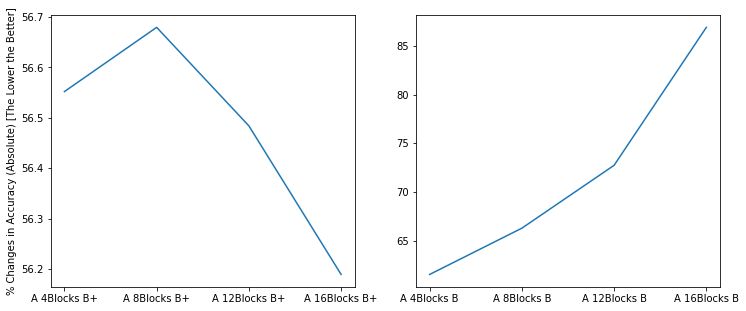

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plt.sca(axs[0])
plt.plot([4, 8, 12, 16], [adversarial_performance["A_4blocks_B"]["abs_percent_changes"] * 100, adversarial_performance["A_8blocks_B"]["abs_percent_changes"] * 100, adversarial_performance["A_12blocks_B"]["abs_percent_changes"] * 100, adversarial_performance["A_16blocks_B"]["abs_percent_changes"] * 100])
plt.xticks([4, 8, 12, 16], ["A 4Blocks B+", "A 8Blocks B+", "A 12Blocks B+", "A 16Blocks B+"])
plt.ylabel("% Changes in Accuracy (Absolute) [The Lower the Better]")

plt.sca(axs[1])
plt.plot([4, 8, 12, 16], [adversarial_performance["A_4blocks_B_freeze"]["abs_percent_changes"] * 100, adversarial_performance["A_8blocks_B_freeze"]["abs_percent_changes"] * 100, adversarial_performance["A_12blocks_B_freeze"]["abs_percent_changes"] * 100, adversarial_performance["A_16blocks_B_freeze"]["abs_percent_changes"] * 100])
plt.xticks([4, 8, 12, 16], ["A 4Blocks B", "A 8Blocks B", "A 12Blocks B", "A 16Blocks B"])

plt.savefig("adversarial_performance.png", dpi=1200, bbox_inches="tight")
plt.show()

---